In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import LibDataImport
import weather
import cPickle
import os.path

In [2]:
# Load utilization summary data into a DataFrame, one column per computer.
pkl = open(os.path.join('..', 'data', 'LibData.pkl'), 'rb')
utilization = cPickle.load(pkl)
pkl.close()

# Remove RRK001 because it seems to always be on, which is unlikely to be due to student use.
# Convert utilization units to %.
utilization = utilization.drop(['RRK001'], axis=1).apply(lambda x: x * 100.0)

In [3]:
utilization.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66381 entries, 2010-03-24 12:00:00 to 2017-10-19 08:00:00
Freq: H
Columns: 311 entries, BL001 to TL902
dtypes: float64(311)
memory usage: 158.0 MB


In [4]:
# Pull in weather data.
pkl = open(os.path.join('..', 'data', 'WeatherData.pkl'), 'rb')
gsoWeather = cPickle.load(pkl)
pkl.close()
gsoWeather.index

DatetimeIndex(['2010-07-01 00:23:00', '2010-07-01 00:54:00',
               '2010-07-01 01:00:00', '2010-07-01 01:54:00',
               '2010-07-01 02:52:00', '2010-07-01 02:54:00',
               '2010-07-01 03:27:00', '2010-07-01 03:54:00',
               '2010-07-01 04:00:00', '2010-07-01 04:10:00',
               ...
               '2017-08-22 14:54:00', '2017-08-22 15:54:00',
               '2017-08-22 16:00:00', '2017-08-22 16:54:00',
               '2017-08-22 18:54:00', '2017-08-22 19:54:00',
               '2017-08-22 20:54:00', '2017-08-22 21:54:00',
               '2017-08-22 22:54:00', '2017-08-22 23:54:00'],
              dtype='datetime64[ns]', name=u'DATE', length=100011, freq=None)

In [5]:
# Our library data contains records from 2010-03-24 to 2017-10-19.
# The weather data contains records from 2010-07-01 to 2017-08-21.
# Trim the datasets down to the intersection of these date ranges.
gsoWeather = gsoWeather[(gsoWeather.index >= '2010-07-01') & (gsoWeather.index < '2017-08-22')]
print(gsoWeather.index)
utilization = utilization[(utilization.index >= '2010-07-01') & (utilization.index < '2017-08-22')]
print(utilization.index)

DatetimeIndex(['2010-07-01 00:23:00', '2010-07-01 00:54:00',
               '2010-07-01 01:00:00', '2010-07-01 01:54:00',
               '2010-07-01 02:52:00', '2010-07-01 02:54:00',
               '2010-07-01 03:27:00', '2010-07-01 03:54:00',
               '2010-07-01 04:00:00', '2010-07-01 04:10:00',
               ...
               '2017-08-21 17:54:00', '2017-08-21 18:54:00',
               '2017-08-21 19:00:00', '2017-08-21 19:54:00',
               '2017-08-21 20:54:00', '2017-08-21 21:54:00',
               '2017-08-21 22:00:00', '2017-08-21 22:54:00',
               '2017-08-21 23:54:00', '2017-08-21 23:59:00'],
              dtype='datetime64[ns]', name=u'DATE', length=99982, freq=None)
DatetimeIndex(['2010-07-01 00:00:00', '2010-07-01 01:00:00',
               '2010-07-01 02:00:00', '2010-07-01 03:00:00',
               '2010-07-01 04:00:00', '2010-07-01 05:00:00',
               '2010-07-01 06:00:00', '2010-07-01 07:00:00',
               '2010-07-01 08:00:00', '2010-07-01

In [6]:
# Make this notebook useful for something.
%matplotlib inline

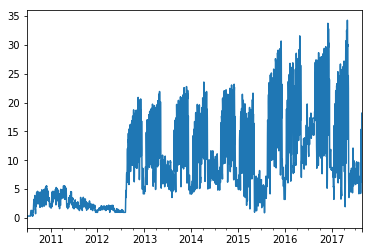

In [7]:
# Resample the utilization data to daily and monthly periods for cases where we don't care about intra-day trends.
daily = utilization.resample('D').mean()
monthly = utilization.resample('M').mean()
hourlyAggregate = utilization.apply(lambda x: x.mean(), axis=1)
dailyAggregate = daily.apply(lambda x: x.mean(), axis=1)
monthlyAggregate = monthly.apply(lambda x: x.mean(), axis=1)

# There seems to be a pretty clear weekly trend here, though...
dailyAggregate.plot()

In [8]:
# Now, we really only need some of these columns.
gsoHourlyWeather = weather.hourlyWeatherOnly(gsoWeather)

# Initially, let's just focus on temperature, wind-speed, and precipitation.
columnsOfInterest = [ 'HOURLYWETBULBTEMPF'
                    , 'HOURLYDRYBULBTEMPF'
                    , 'HOURLYWindSpeed'
                    , 'HOURLYWindGustSpeed'
                    , 'HOURLYPrecip' ]
gsoWeatherCore = gsoHourlyWeather[columnsOfInterest]

# Clean up incorrect values.
gsoWeatherCore = gsoWeatherCore.replace(to_replace='[^0-9.-]', value='', regex=True)
gsoWeatherCore = gsoWeatherCore.replace(to_replace='', value='0').apply(np.float64)
gsoWeatherInterp = gsoWeatherCore.resample('H').interpolate()
gsoWeatherCore.head()

,HOURLYWETBULBTEMPF,HOURLYDRYBULBTEMPF,HOURLYWindSpeed,HOURLYWindGustSpeed,HOURLYPrecip
DATE,,,,,
2010-07-01 00:23:00,68.0,72.0,0.0,NaN,NaN
2010-07-01 00:54:00,67.0,70.0,0.0,NaN,0.0
2010-07-01 01:00:00,67.0,70.0,0.0,NaN,NaN
2010-07-01 01:54:00,67.0,70.0,0.0,NaN,0.0
2010-07-01 02:52:00,66.0,70.0,0.0,NaN,NaN


In [9]:
# Now if we resample this to daily or monthly aggregate values, some columns
# need to have their values averaged, and others need to be summed.

def aggregateMatrix(df, period=None):
    needAverage = df[columnsOfInterest[:-1]]
    needSum = df['HOURLYPrecip']
    if period!=None:
        needAverage = needAverage.resample(period)
        needSum = needSum.resample(period)
    periodAverage = needAverage.mean()
    periodSum = needSum.sum()
    return periodAverage.join(periodSum, how='inner')

# Now re-join these...
dailyWeather = aggregateMatrix(gsoWeatherCore, 'D')
monthlyWeather = aggregateMatrix(gsoWeatherCore, 'M')

# And finally join with library data.  This gives us individual computer usage, as well as a subset of
# the weather data, in hourly, daily, and monthly periods.
matrixHourly = pd.DataFrame(hourlyAggregate, columns=['Utilization(%)']).join(gsoWeatherInterp, how='inner')
matrixDaily = pd.DataFrame(dailyAggregate, columns=['Utilization(%)']).join(dailyWeather, how='inner')
matrixMonthly = pd.DataFrame(monthlyAggregate, columns=['Utilization(%)']).join(monthlyWeather, how='inner')

In [10]:
# It might be interesting to look at this data by each day of the week, too.
daysOfWeek = [ 'Monday'
             , 'Tuesday'
             , 'Wednesday'
             , 'Thursday'
             , 'Friday'
             , 'Saturday'
             , 'Sunday' ]

matrixDaily['Day of week'] = [daysOfWeek[d] for d in matrixDaily.index.dayofweek]

In [11]:
# Summary by day of week...
matrixDaily.groupby(by='Day of week').mean()

,Utilization(%),HOURLYWETBULBTEMPF,HOURLYDRYBULBTEMPF,HOURLYWindSpeed,HOURLYWindGustSpeed,HOURLYPrecip
Day of week,,,,,,
Friday,8.607397,53.253810,59.646199,6.884416,22.129844,0.240430
Monday,11.628152,54.209949,60.369948,7.101587,22.151596,0.289865
Saturday,6.320266,52.914841,59.307872,6.596918,21.331879,0.213324
Sunday,7.805598,53.239631,59.655905,6.736034,21.551346,0.184758
Thursday,11.278032,54.073802,60.454292,6.862880,21.885315,0.214826
Tuesday,12.012063,54.583046,60.630585,6.998291,22.215055,0.311159
Wednesday,12.061272,54.666325,60.929082,6.738595,21.629360,0.252473


In [12]:
# When considering the entire dataset, there is no correlation between utilization and outside temperature.
matrixHourly[['Utilization(%)','HOURLYDRYBULBTEMPF']].corr()

,Utilization(%),HOURLYDRYBULBTEMPF
Utilization(%),1.000000,0.043218
HOURLYDRYBULBTEMPF,0.043218,1.000000


In [13]:
def hexPlot(x, y, title, xlabel, ylabel):
    fig = plt.figure(figsize=(16,16))
    hb = plt.hexbin(x, y, bins='log', gridsize=75)
    hb.axes.set_title(title)
    hb.axes.set_xlabel(xlabel)
    hb.axes.set_ylabel(ylabel)
    cb = fig.colorbar(hb)
    cb.set_label('log(N)')

In [14]:
x = matrixHourly['HOURLYDRYBULBTEMPF']
y = matrixHourly['Utilization(%)']
#hexPlot(x, y, 'Aggregate computer use vs. temperature, hourly', 'Temperature(F)', 'Use(%)')

In [15]:
merged = gsoWeatherInterp[['HOURLYDRYBULBTEMPF']].join(utilization, how='inner')
merged.info()

computerUsage = merged.drop(['HOURLYDRYBULBTEMPF'], axis=1)
temps = merged['HOURLYDRYBULBTEMPF']

temps = np.hstack([temps] * len(computerUsage.columns))
usage = np.hstack([x.values for (_,x) in computerUsage.iteritems()])
#hexPlot(temps, usage, 'Individual computer use vs. temperature, hourly', 'Temperature(F)', 'Use(%)')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62616 entries, 2010-07-01 00:00:00 to 2017-08-21 23:00:00
Freq: H
Columns: 312 entries, HOURLYDRYBULBTEMPF to TL902
dtypes: float64(312)
memory usage: 149.5 MB


In [16]:
import seaborn as sns

matrixHourly.corr()

/usr/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


,Utilization(%),HOURLYWETBULBTEMPF,HOURLYDRYBULBTEMPF,HOURLYWindSpeed,HOURLYWindGustSpeed,HOURLYPrecip
Utilization(%),1.000000,-0.006096,0.043218,0.158239,-0.150960,0.020578
HOURLYWETBULBTEMPF,-0.006096,1.000000,0.960888,-0.025286,0.046193,0.195649
HOURLYDRYBULBTEMPF,0.043218,0.960888,1.000000,0.025825,0.042433,0.196254
HOURLYWindSpeed,0.158239,-0.025286,0.025825,1.000000,0.004829,-0.040830
HOURLYWindGustSpeed,-0.150960,0.046193,0.042433,0.004829,1.000000,0.013209
HOURLYPrecip,0.020578,0.195649,0.196254,-0.040830,0.013209,1.000000


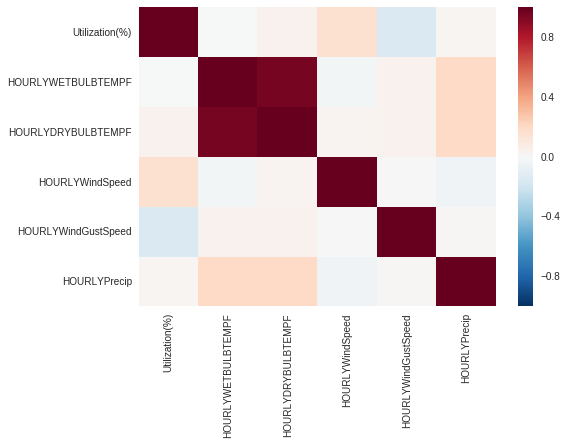

In [17]:
sns.heatmap(matrixHourly.corr())

In [18]:
utilization = utilization[1:]
gsoWeatherInterp = gsoWeatherInterp[1:]
print(utilization.head())
print(gsoWeatherInterp.head())

                     BL001  BL002  CITI001  CITI002  CITI003  CITI004  \
2010-07-01 01:00:00    0.0    0.0      0.0      0.0      0.0      0.0   
2010-07-01 02:00:00    0.0    0.0      0.0      0.0      0.0      0.0   
2010-07-01 03:00:00    0.0    0.0      0.0      0.0      0.0      0.0   
2010-07-01 04:00:00    0.0    0.0      0.0      0.0      0.0      0.0   
2010-07-01 05:00:00    0.0    0.0      0.0      0.0      0.0      0.0   

                     CITI005  CITI006  CITI007  CITI008  ...    TL5002  \
2010-07-01 01:00:00      0.0      0.0      0.0      0.0  ...       0.0   
2010-07-01 02:00:00      0.0      0.0      0.0      0.0  ...       0.0   
2010-07-01 03:00:00      0.0      0.0      0.0      0.0  ...       0.0   
2010-07-01 04:00:00      0.0      0.0      0.0      0.0  ...       0.0   
2010-07-01 05:00:00      0.0      0.0      0.0      0.0  ...       0.0   

                     TL6001  TL6002  TL7001  TL702  TL801  TL802  TL90003  \
2010-07-01 01:00:00     0.0     0.0    

In [19]:
stacked = utilization.join(gsoWeatherInterp, how='inner')
stacked = (stacked - stacked.mean()) / stacked.std()
cc = stacked.corr()

## Correlation heat matrix of individual computer use and hourly weather

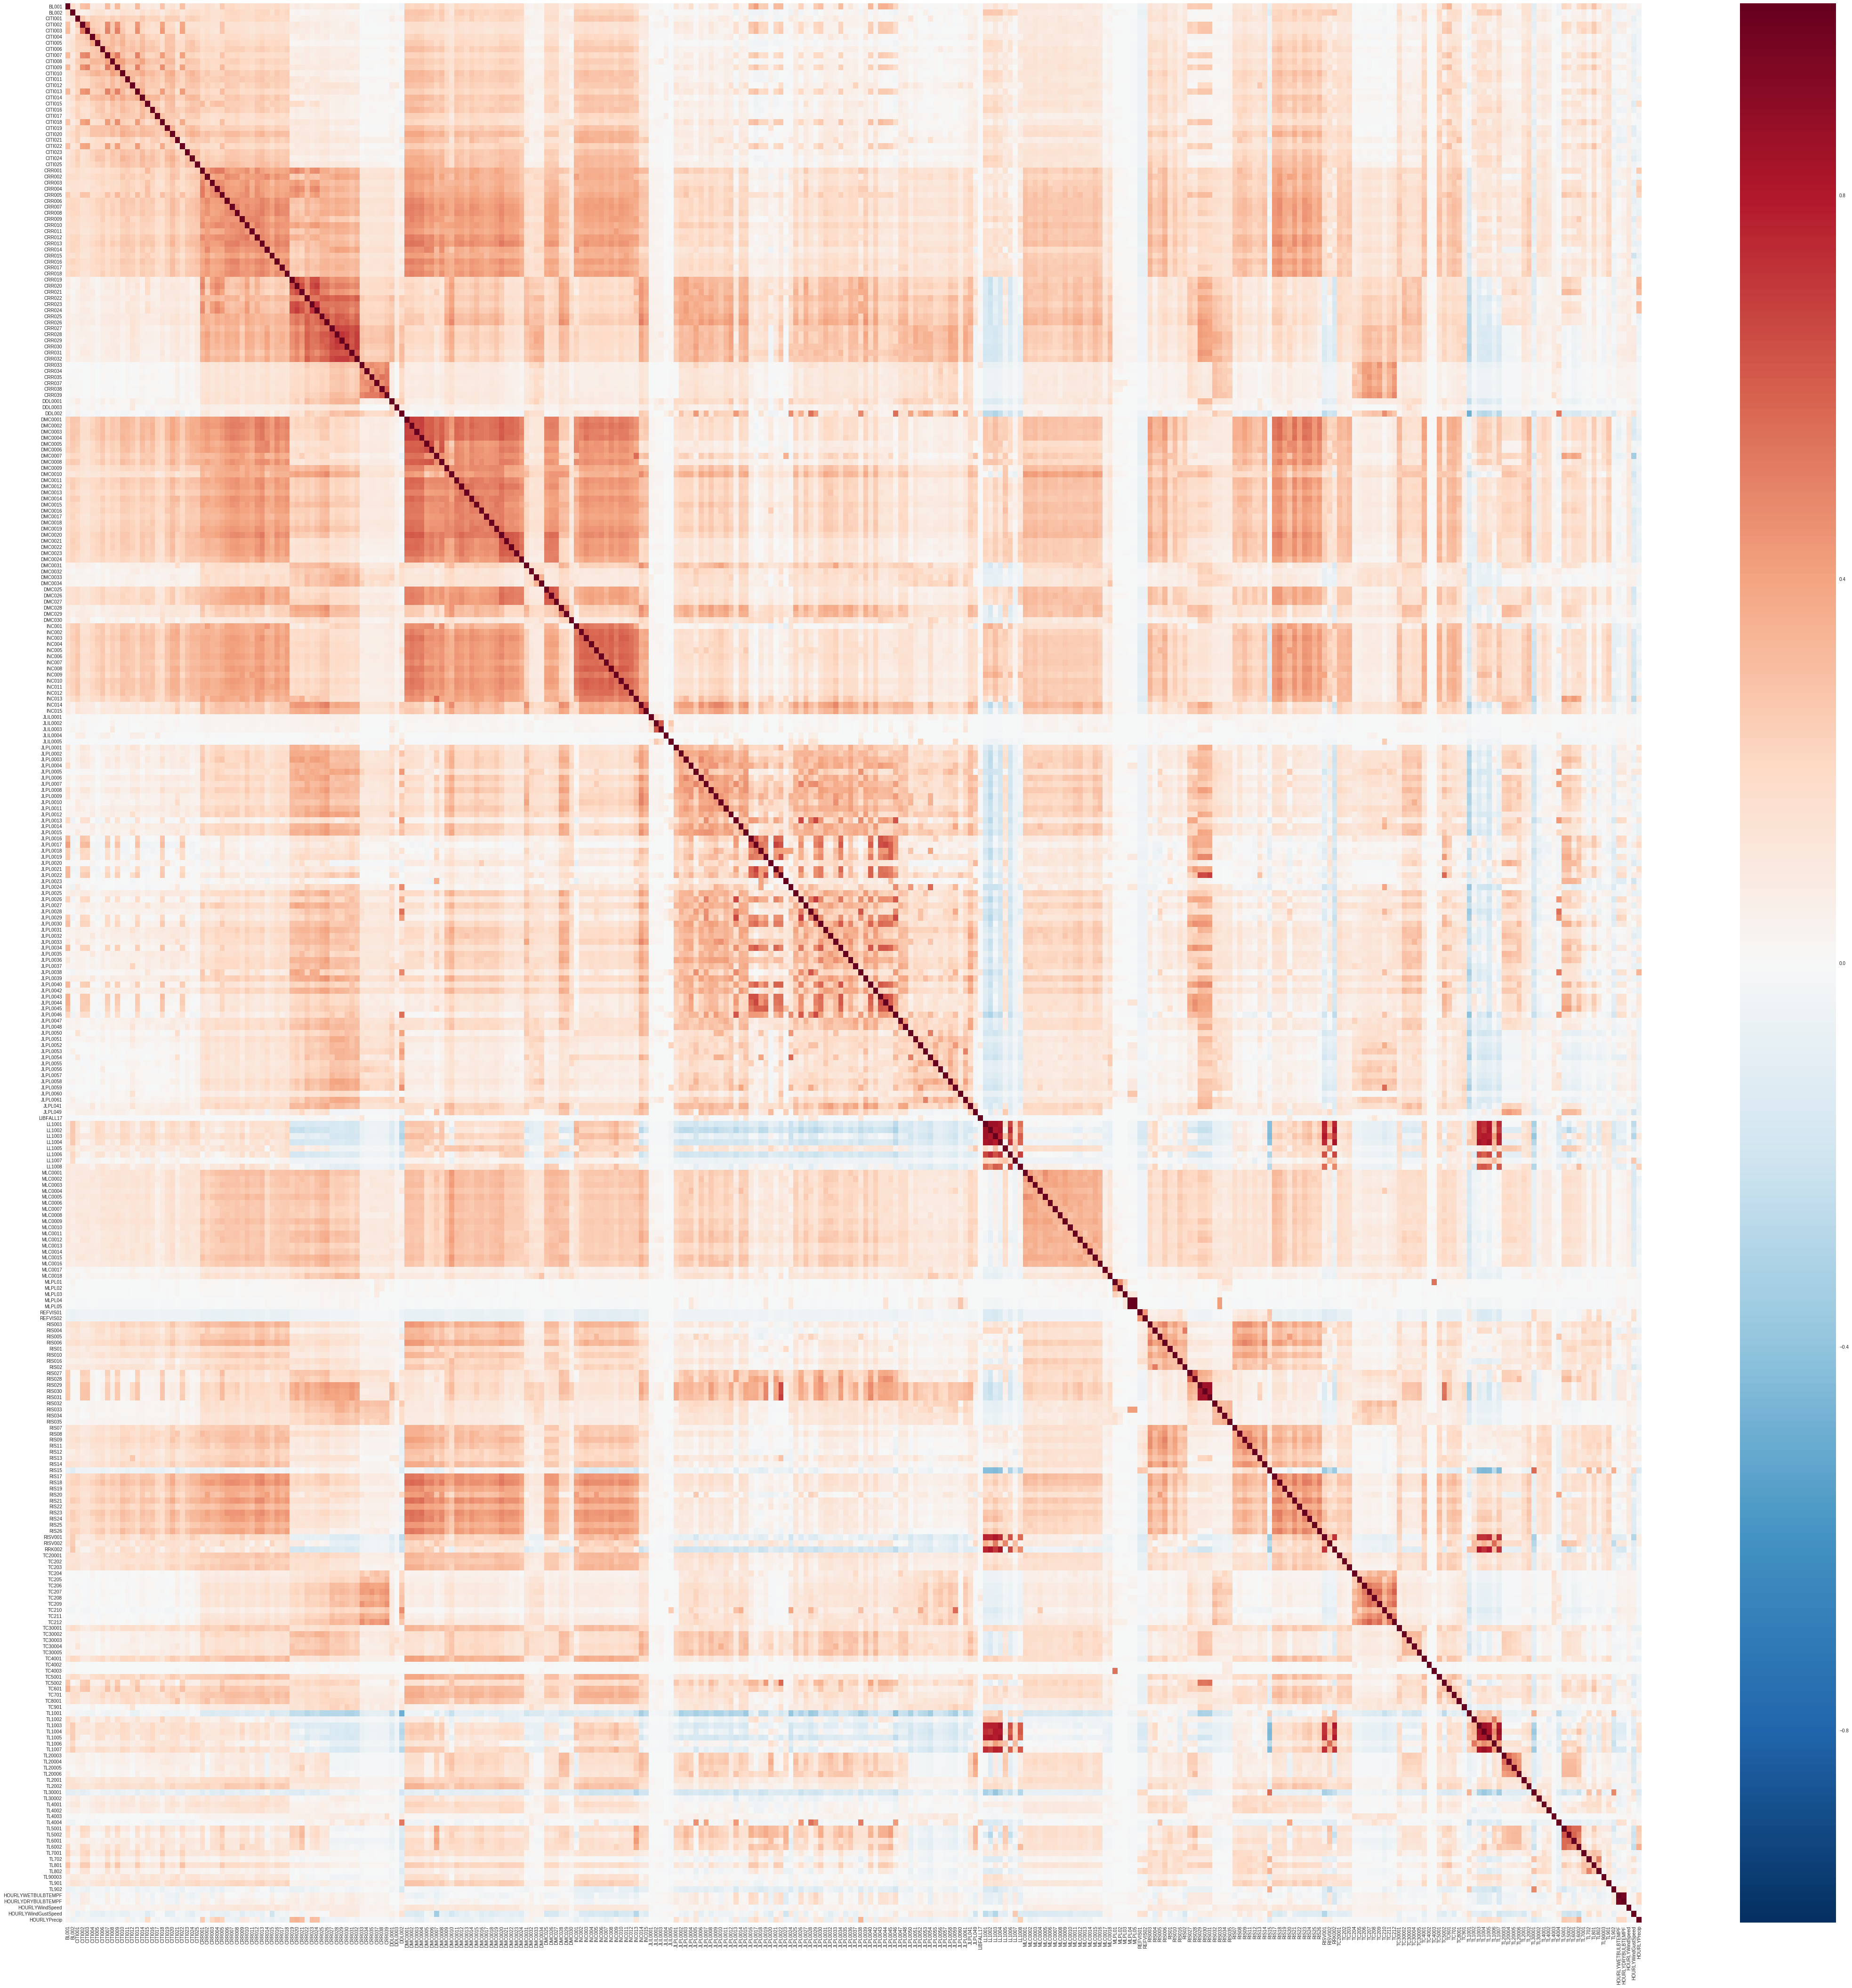

In [20]:
fig, ax = plt.subplots(figsize=(75,75))
sns.heatmap(cc, ax=ax)

In [46]:
attributes = pd.read_csv(os.path.join('..', 'data', 'computerAttributes.csv'))
attributes = attributes[attributes['computerName']!='RRK001']

In [47]:
locations = attributes[['computerName', 'location']].groupby(by='location')

In [55]:
groups = {}
for (k, vs) in locations:
    stacked_ = utilization[vs['computerName'].values].join(gsoWeatherInterp, how='inner')
    stacked_ = (stacked_ - stacked_.mean()) / stacked_.std()
    groups[k] = stacked_
groups.keys()

['Reading Room',
 'Checkout Desk',
 'DMC',
 'na',
 'Info Commons',
 'RIS',
 'Music Library',
 'Tower',
 'CITI Lab',
 'Linking Lobby']

## Groups along the main diagonal
Computers are grouped by 'location' attribute of `computerAttributes.csv`.

### Reading rooms

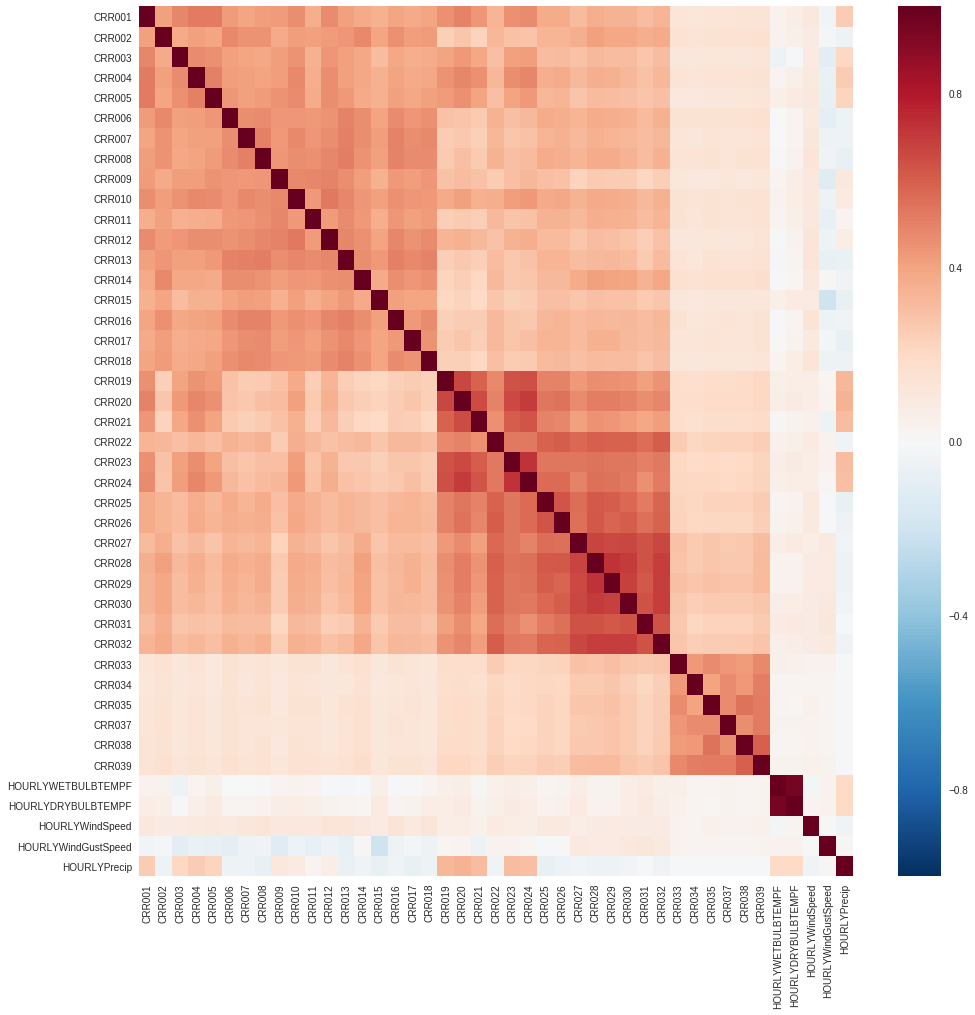

In [54]:
_, ax = plt.subplots(figsize=(16,16))
sns.heatmap(groups['Reading Room'].corr(), ax=ax)

### Checkout desk

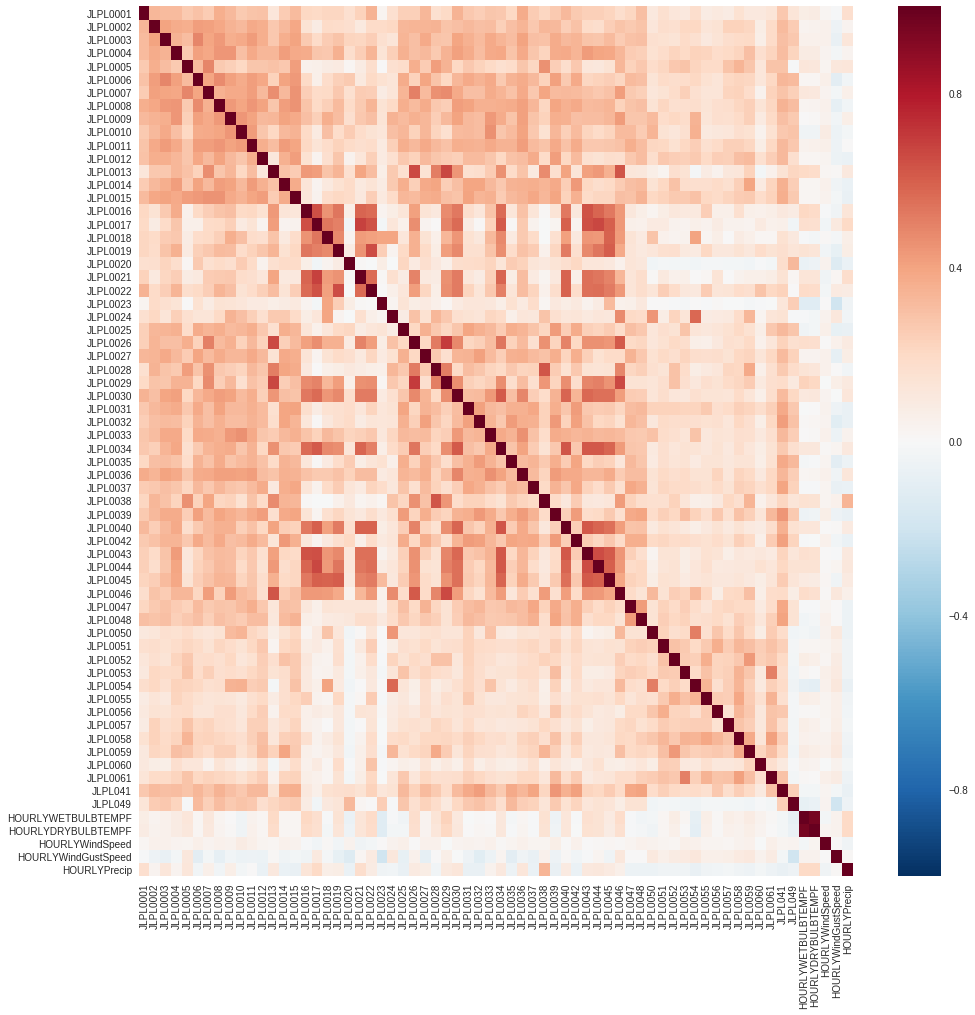

In [56]:
_, ax = plt.subplots(figsize=(16,16))
sns.heatmap(groups['Checkout Desk'].corr(), ax=ax)

### DMC

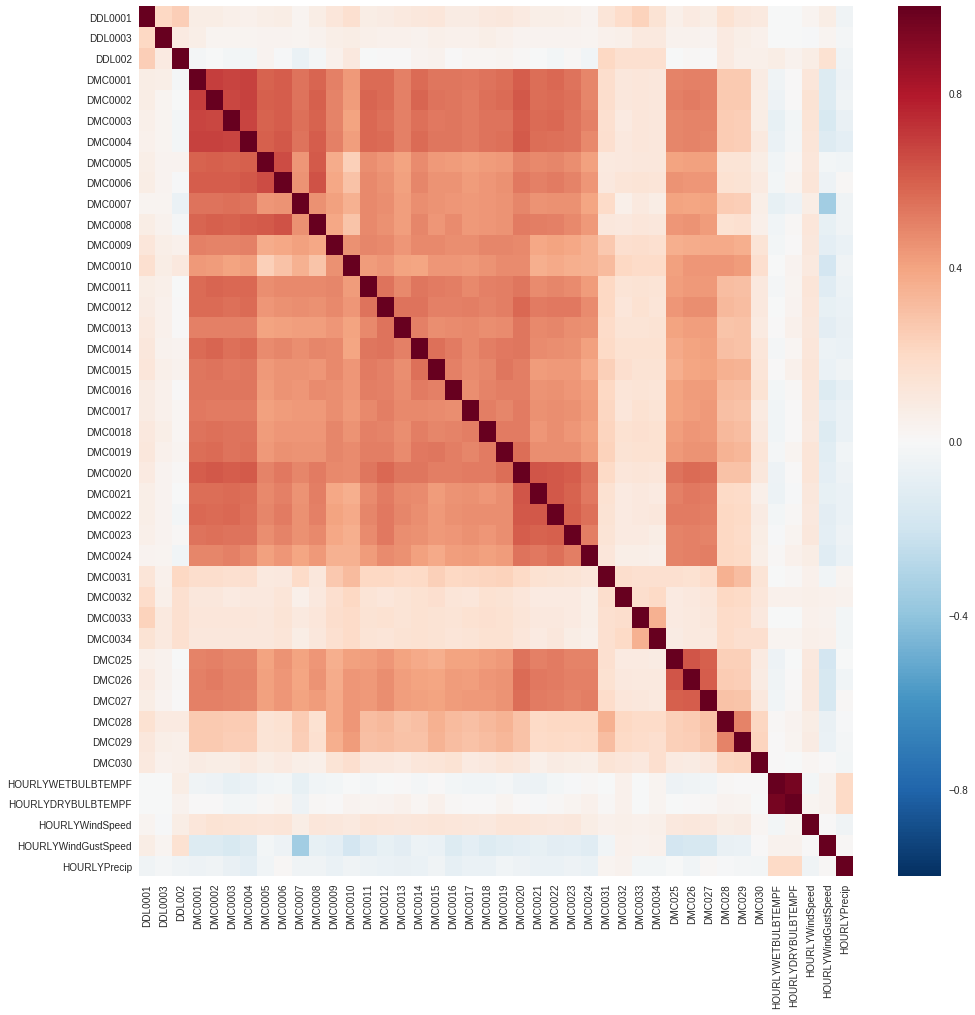

In [57]:
_, ax = plt.subplots(figsize=(16,16))
sns.heatmap(groups['DMC'].corr(), ax=ax)

### Information commons

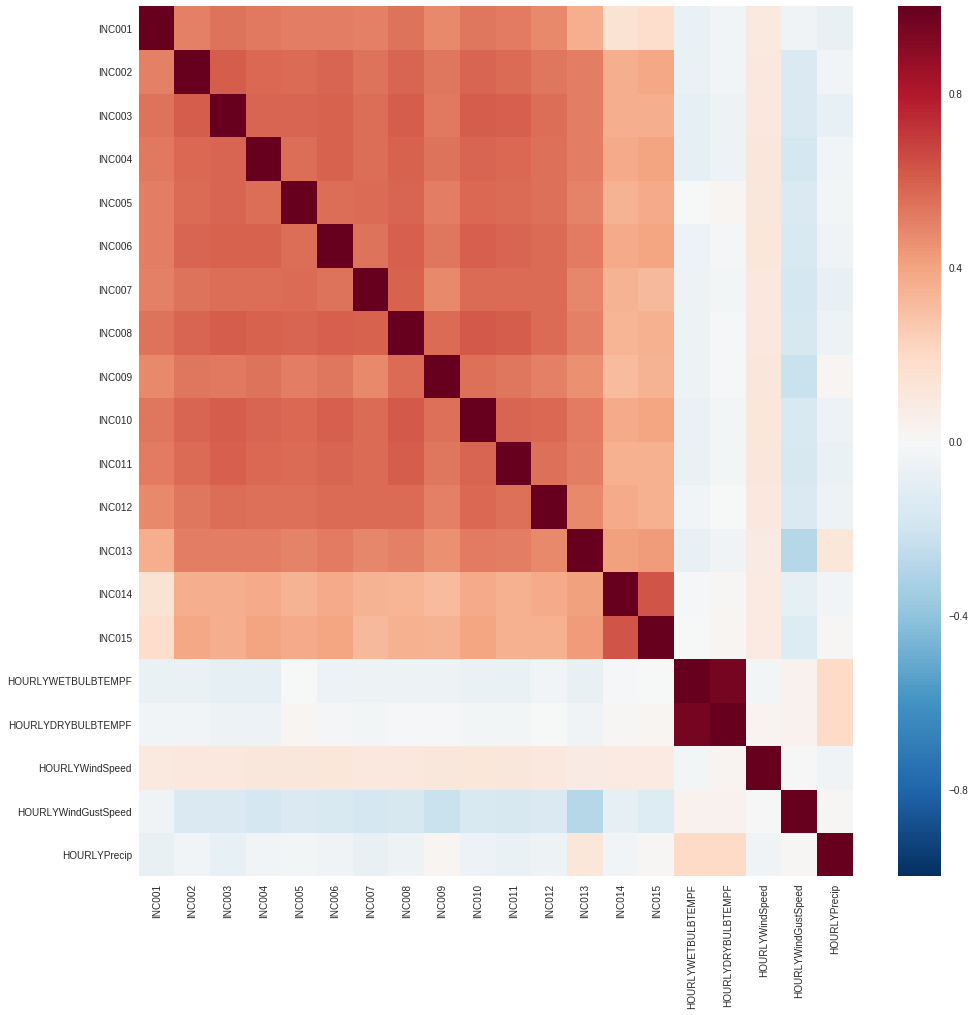

In [58]:
_, ax = plt.subplots(figsize=(16,16))
sns.heatmap(groups['Info Commons'].corr(), ax=ax)

### RIS

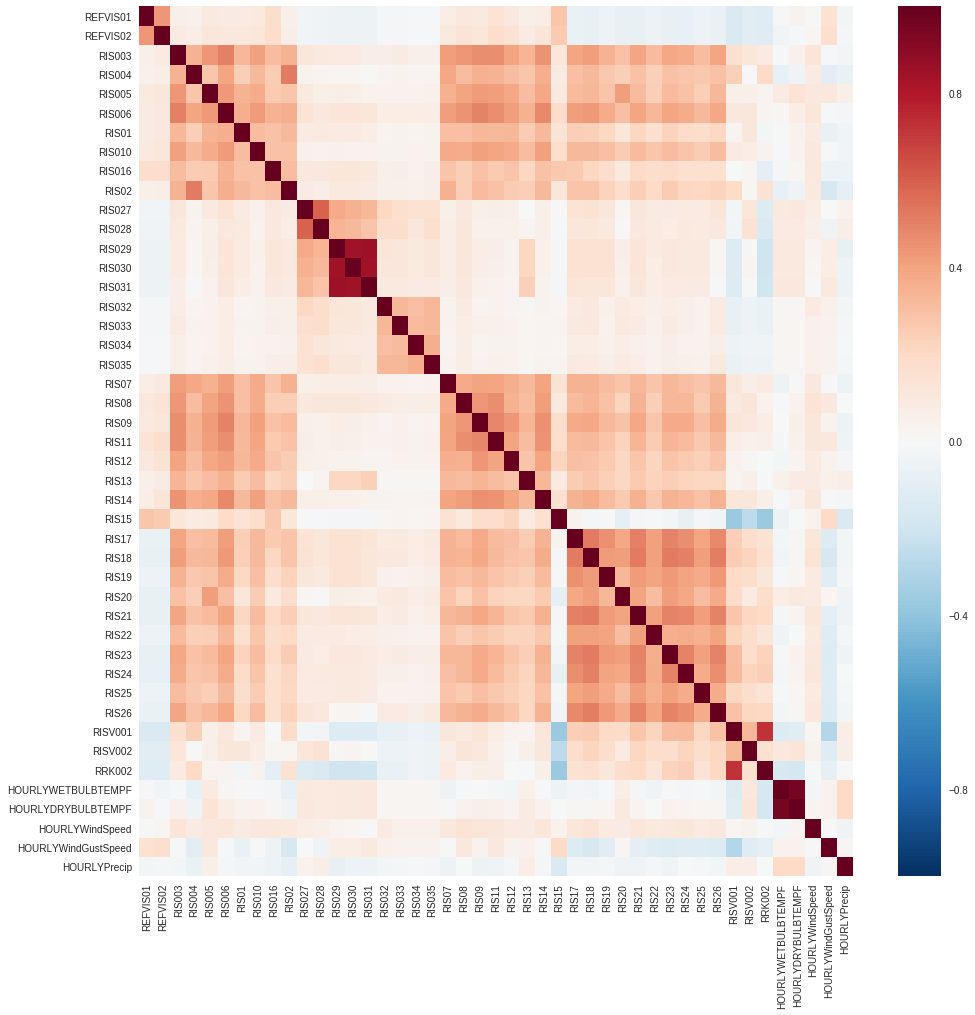

In [59]:
_, ax = plt.subplots(figsize=(16,16))
sns.heatmap(groups['RIS'].corr(), ax=ax)

### Music library

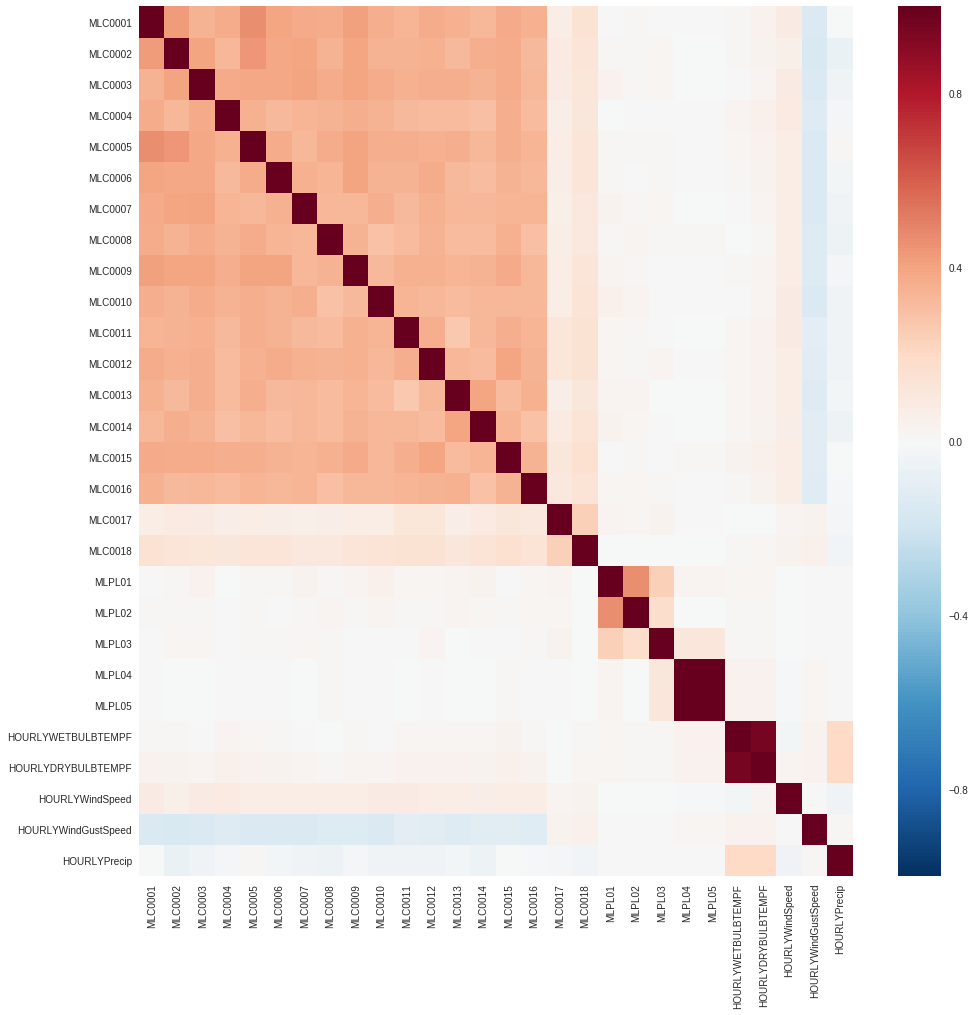

In [60]:
_, ax = plt.subplots(figsize=(16,16))
sns.heatmap(groups['Music Library'].corr(), ax=ax)

### Tower

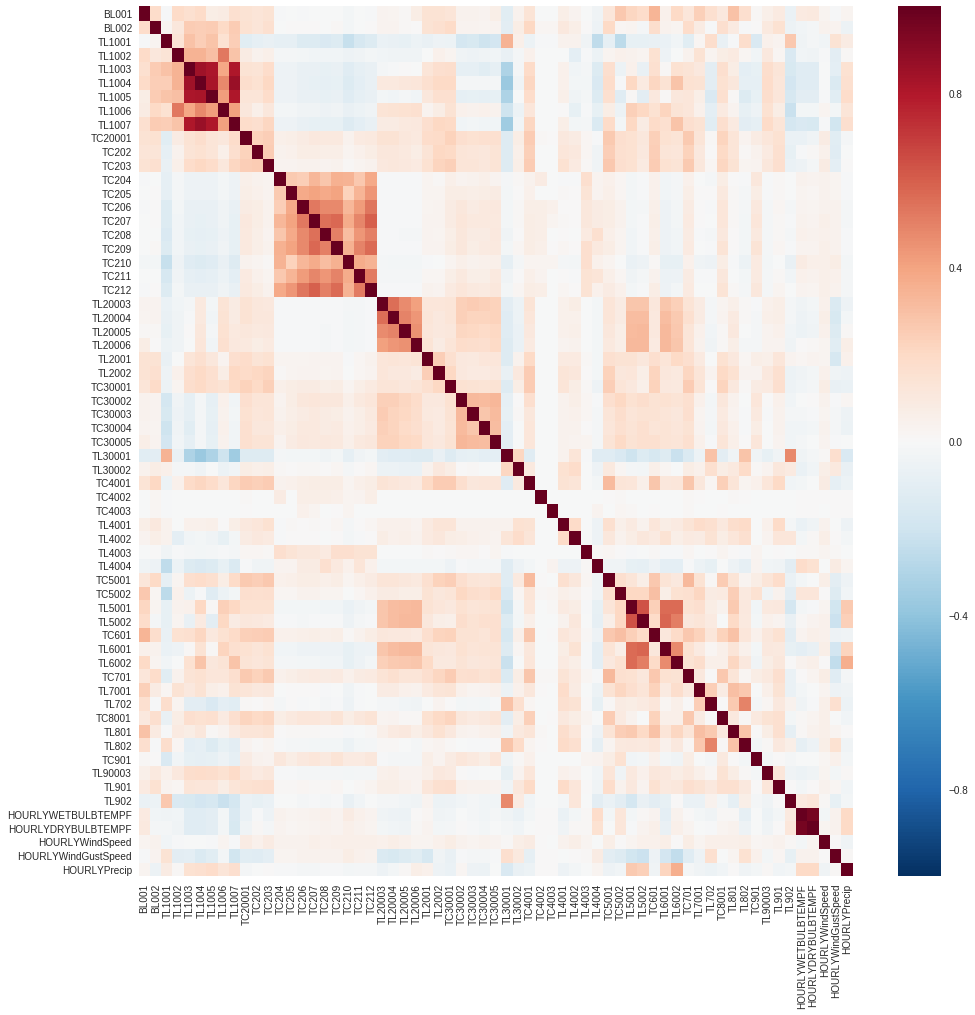

In [61]:
_, ax = plt.subplots(figsize=(16,16))
sns.heatmap(groups['Tower'].corr(), ax=ax)

### CITI lab

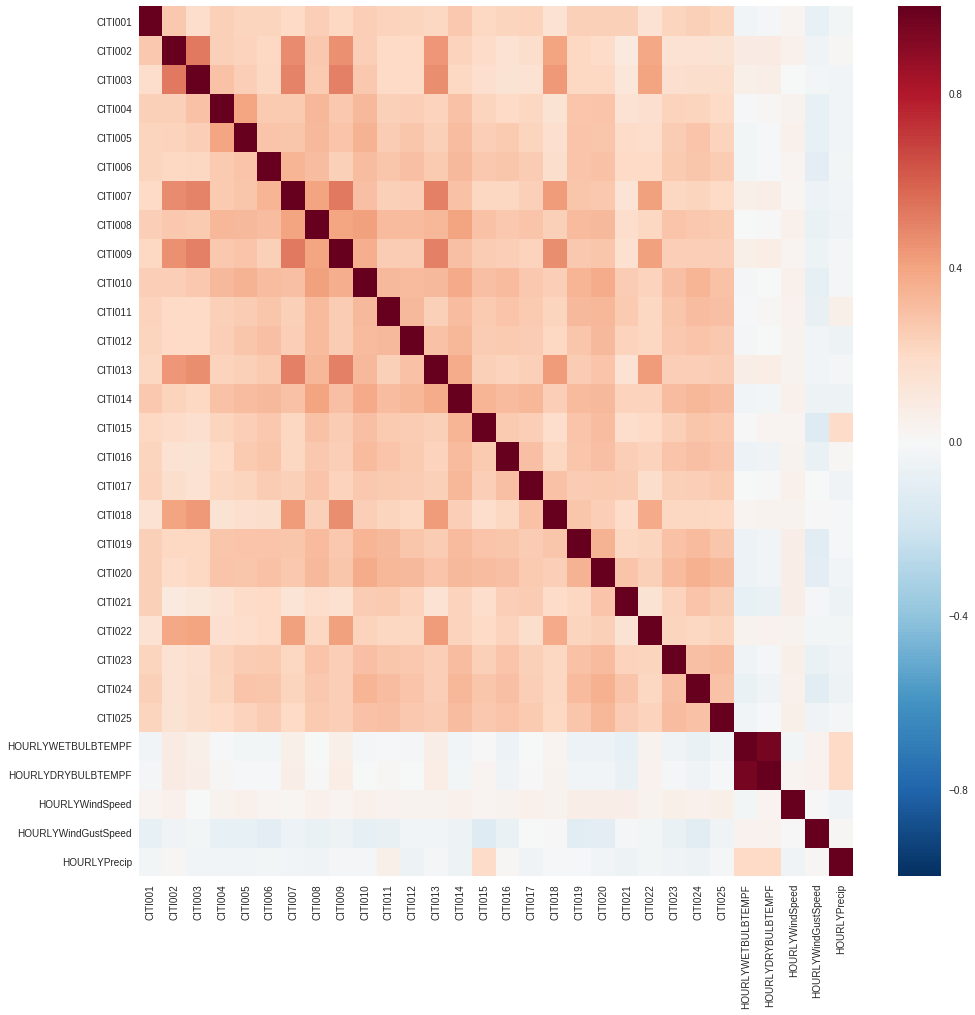

In [62]:
_, ax = plt.subplots(figsize=(16,16))
sns.heatmap(groups['CITI Lab'].corr(), ax=ax)

### Linking lab

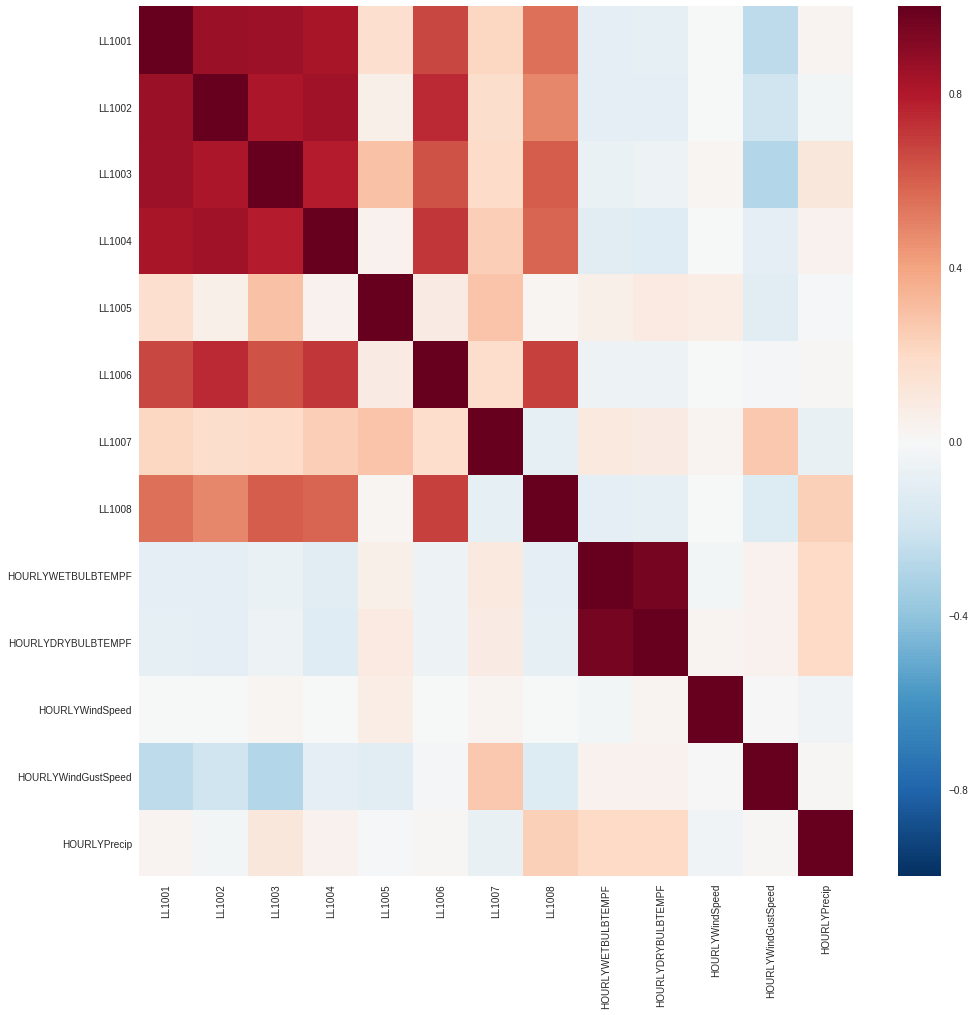

In [63]:
_, ax = plt.subplots(figsize=(16,16))
sns.heatmap(groups['Linking Lobby'].corr(), ax=ax)